In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [123]:
cred = pd.read_csv('credit_card_default_analysis.csv')
cred.sample(5).T

,837,15071,23624,3598,24173
ID,838,15072,23625,3599,24174
LIMIT_BAL,110000,110000,410000,240000,140000
SEX,2,1,2,1,1
EDUCATION,2,2,1,1,2
MARRIAGE,1,1,2,1,2
AGE,55,35,31,35,24
PAY_0,0,1,0,1,0
PAY_2,0,2,0,0,0
PAY_3,0,0,0,0,0
PAY_4,0,0,0,0,0


#  Размер кредитного лимита (LIMIT_BAL)

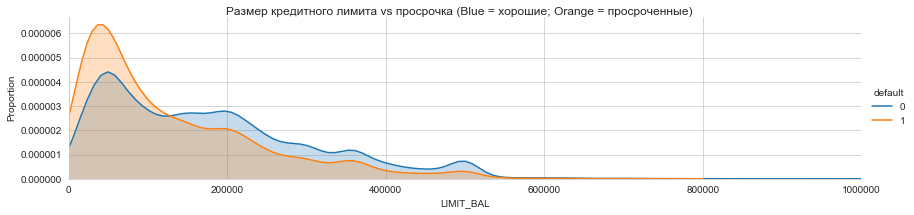

In [3]:
sns.set_style("whitegrid")
plotOne = sns.FacetGrid(cred, hue="default",aspect=4)
plotOne.map(sns.kdeplot,'LIMIT_BAL',shade=True)
plotOne.set(xlim=(0, cred['LIMIT_BAL'].max()))
plotOne.add_legend()
plotOne.set_axis_labels('LIMIT_BAL', 'Proportion')
plotOne.fig.suptitle('Размер кредитного лимита vs просрочка (Blue = хорошие; Orange = просроченные)');

## Интервальная оценка разности медиан на основе bootstrap

* $H_0$: медианные значения равны


* $H_1$: медианные значения отличаются

Проверка гипотез:

a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [5]:
limbal_good = cred.query("default == 0")['LIMIT_BAL'].values
limbal_bad = cred.query("default == 1")['LIMIT_BAL'].values

In [6]:
np.random.seed(0)

good_median_scores = map(np.median, get_bootstrap_samples(limbal_good, 100))
bad_median_scores = map(np.median, get_bootstrap_samples(limbal_bad, 100))

delta_median_scores = map(lambda x: x[1] - x[0], zip(bad_median_scores, good_median_scores))
print ("95% confidence interval for the difference between medians", stat_intervals(list(delta_median_scores), 0.05))

95% confidence interval for the difference between medians [60000. 70000.]


*Интервальная оценка не содержит ноль, похоже, медианы не равны.*

## Перестановочный критерий (непараметрический критерий проверки равенства средних)

Выборки независимы, так как имеют различные объекты

* $H_0\colon F_{X_1}(x) = F_{X_2}(x)$


* $H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

In [8]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in list(range(max_combinations - 1)):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [9]:
np.random.seed(0)
print("p-value: %f" % permutation_test(limbal_good, limbal_bad, 1000))

p-value: 0.001000


*95% доверительный интервал для разности медиан лежит в промежутке между 60000 и 70000, нулевая гипотеза о равенстве распределений отвергается на уровне значимости 5%. Результат практически значим.*

# Пол (SEX)

Процентное соотношение полов:
 wemen    0.603733
men      0.396267
Name: SEX, dtype: float64


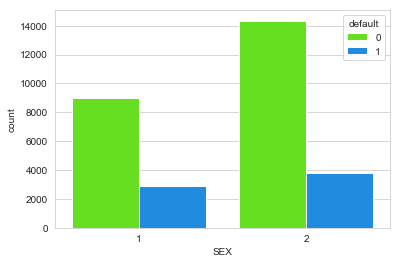

In [10]:
print('Процентное соотношение полов:\n', cred.SEX.value_counts(normalize=True).rename({2: 'wemen', 1: 'men'}))
sns.set_style("whitegrid")
sns.countplot(x='SEX',hue='default',data=cred, palette='gist_rainbow');

* $H_0$: Гендерный состав групп не отличается


* $H_1$: Гендерный состав отличается

## Интервальная оценка. Z-критерий для разности долей (независимые выборки)

In [16]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [31]:
good_temp = cred.query('default == 0').SEX==2
bad_temp = cred.query('default == 1').SEX==2

In [32]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
                              proportions_diff_confint_ind(good_temp, bad_temp))

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


*Интервал не содержит ноль, похоже, гендерный состав вернувших и не вернувших кредит отличается.*

## Z-критерий для разности долей (независимые выборки)

In [33]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [37]:
print("p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(good_temp, bad_temp)))

p-value: 4.472866521609831e-12


*При уровне значимости 5% гендерный состав группы людей вернувших и не вернувших кредит отличается.*

# Образование (EDUCATION)

In [113]:
dct_edu = {0: 'доктор', 1: 'магистр', 2: 'бакалавр', 3: 'выпускник школы',
           4: 'начальное образование', 5: 'прочее', 6: 'нет данных'}

ct = pd.crosstab(cred.EDUCATION, cred.default). \
                rename(columns={0:'good', 1:'bad'},
                       index=dct_edu)
                    
ct.assign(diff = ct.good - ct.bad, 
          pct_good = np.round((ct.good - ct.bad) / ct.good * 100., 2).map(lambda x: str(x)+'%'))

default,good,bad,diff,pct_good
EDUCATION,,,,
доктор,14,0,14,100.0%
магистр,8549,2036,6513,76.18%
бакалавр,10700,3330,7370,68.88%
выпускник школы,3680,1237,2443,66.39%
начальное образование,116,7,109,93.97%
прочее,262,18,244,93.13%
нет данных,43,8,35,81.4%


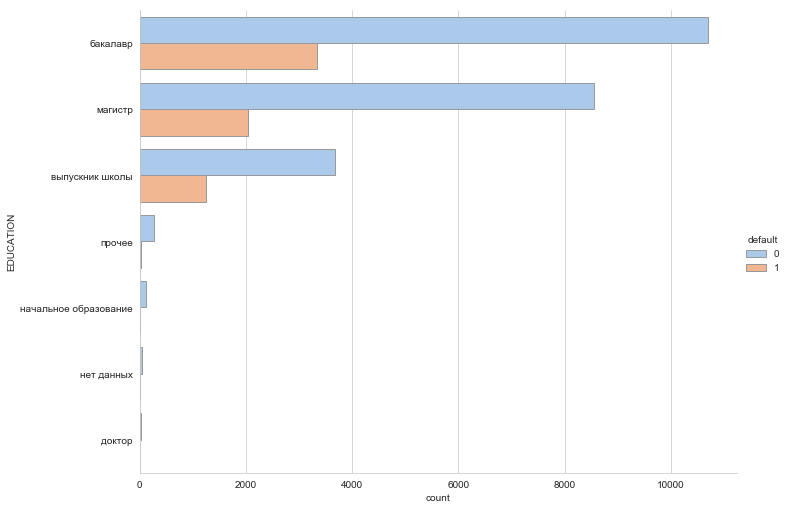

In [141]:
cred_edu = cred.copy()
cred_edu.EDUCATION = cred_edu.EDUCATION.map(dct_edu)

sns.catplot(y="EDUCATION", hue="default", kind="count",
            palette="pastel", edgecolor=".6", height=7, 
            aspect=1.5, data=cred_edu);

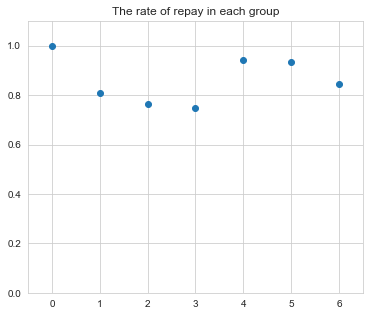

In [64]:
prop0 = np.bincount(cred.query("default == 0")['EDUCATION'])*1. / np.bincount(cred.EDUCATION)

pylab.figure(figsize = (6,5))
pylab.axis([-0.5, 6.5, 0, 1.1])
pylab.scatter(range(7), prop0)
pylab.title('The rate of repay in each group');

*У выпускников школ наибольший проента дефолтов. Далее - бакалавры и магистры.
Меньше всего невозвратов у докторов - 0. Далее - "начальное", "прочее" и "нет данных".*

## Критерий согласия Пирсона ( $\chi^2$)

* $H_0$: Рассматриваемая величина имеет Равномерное распределение 


* $H_1$: $H_0$ неверна

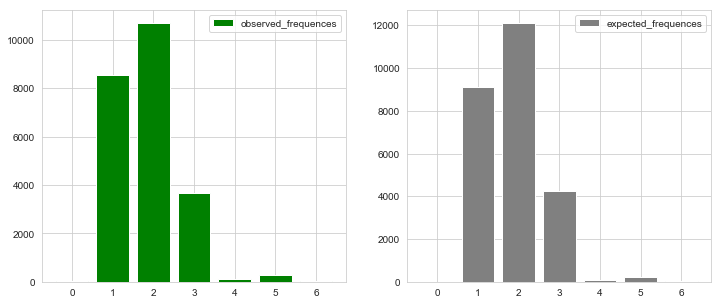

In [145]:
observed_frequences = np.bincount(cred.query("default == 0")['EDUCATION'])
expected_frequences = prop0.mean() * np.bincount(cred.EDUCATION)

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.bar(range(7), observed_frequences, color = 'g', label = 'observed_frequences')
pylab.legend()

pylab.subplot(1,2,2)
pylab.bar(range(7), expected_frequences, color = 'grey', label = 'expected_frequences')
pylab.legend()

pylab.show()

In [143]:
stats.chisquare(observed_frequences, expected_frequences, ddof = 1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

*Нулевая гипотеза не принимается на уровне значимости 5%, что говорит о том, что есть отличия между выплатой кредита разными группами. Результат практически значим, так как разница довольно существенная и логически интуитивна.*

# Семейное положение (MARRIAGE)

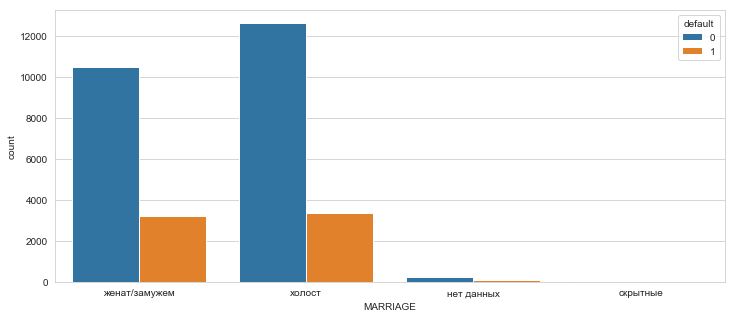

In [147]:
dct_marr = {0: 'скрытные', 1: 'женат/замужем', 2: 'холост', 3: 'нет данных'}
sns.countplot(x=cred.MARRIAGE.map(dct_marr), hue='default', data=cred);

## Коэффициент V Крамера

In [159]:
cm = pd.crosstab(cred.MARRIAGE, cred.default).T
n = cred.shape[0]
hi2 = stats.chi2_contingency(cm)[0]

v_cram = np.sqrt(hi2 / (n * (min(cm.shape)-1)))

print('Коэффициент V Крамера %f - близок к нулю. Семейное положение не связано с дефолтом заемщика.' % v_cram)

Коэффициент V Крамера 0.034478 - близок к нулю. Семейное положение не связано с дефолтом заемщика.


# Возраст (AGE)

In [174]:
pylab.hist?

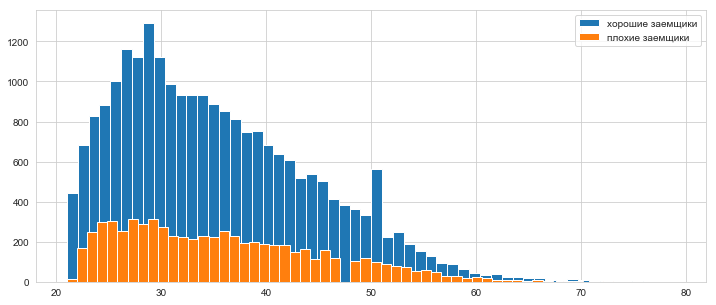

In [178]:
pylab.hist(cred[cred.default == 0].AGE, bins=cred.AGE.nunique(), label='хорошие заемщики')
pylab.hist(cred[cred.default == 1].AGE, bins=cred.AGE.nunique(), label='плохие заемщики')
pylab.legend(loc = 'best');

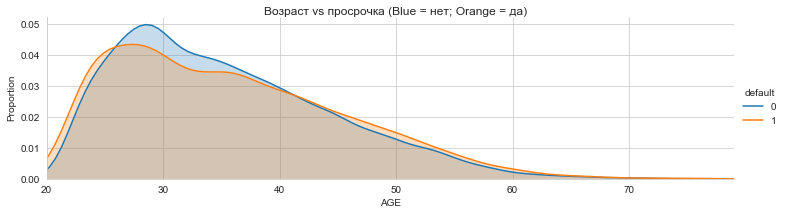

In [163]:
plotTwo = sns.FacetGrid(cred, hue="default",aspect=3.4)
plotTwo.map(sns.kdeplot,'AGE',shade=True)
plotTwo.set(xlim=(cred['AGE'].min()-1, cred['AGE'].max()))
plotTwo.add_legend()
plotTwo.set_axis_labels('AGE', 'Proportion')
plotTwo.fig.suptitle('Возраст vs просрочка (Blue = нет; Orange = да)');

## Интервальная оценка разности медиан на основе bootstrap

*гипотеза:*

a) о равенстве медианных значений возрастов людей

* $H_0$: медианные значения равны


* $H_1$: медианные значения отличаются

In [179]:
good_age = cred.query("default == 0")['AGE'].values
bad_age = cred.query("default == 1")['AGE'].values

In [180]:
np.random.seed(0)

good_median_scores = map(np.median, get_bootstrap_samples(good_age, 100))
bad_median_scores = map(np.median, get_bootstrap_samples(bad_age, 100))

delta_median_scores = map(lambda x: x[1] - x[0], zip(good_median_scores, bad_median_scores))
print ("95% confidence interval for the difference between medians", stat_intervals(list(delta_median_scores), 0.05))

95% confidence interval for the difference between medians [0. 1.]


*Доверительный интервал для разности медиан содержит ноль, поэтому мы не можем отвернуть нулевую гипотезу.*

## Перестановочный критерий для независимых выборок (непараметрический критерий проверки равенства средних)

*гипотеза:*

b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

* $H_0\colon F_{X_1}(x) = F_{X_2}(x)$


* $H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [184]:
np.random.seed(0)
print('p-value: %f' % permutation_test(bad_age, good_age, 1000))

p-value: 0.019000


 *Уровень значимости в 5% не позволяет принять нулевую гипотезу о равенстве распределений. Результат практически значим, так как возраст влияет на выдачу кредита клиенту.*